# Spatial binning

In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
sc.set_figure_params(dpi=100)

## Read HD-ST data

In [3]:
adata = sc.read('results/hdst.h5ad')
adata

AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [4]:
adata.obs['x'] = adata.obsm['X_spatial'][:, 0]
adata.obs['y'] = adata.obsm['X_spatial'][:, 1]

adata.obs.head()

,region,segment,x,y
index,,,,
1000x1,Olfactory Nerve Layer (ONL),0,1000,1
1000x10,Olfactory Nerve Layer (ONL),0,1000,10
1000x100,Olfactory Nerve Layer (ONL),0,1000,100
1000x101,Olfactory Nerve Layer (ONL),0,1000,101
1000x102,Olfactory Nerve Layer (ONL),0,1000,102


... storing 'region' as categorical
... storing 'segment' as categorical


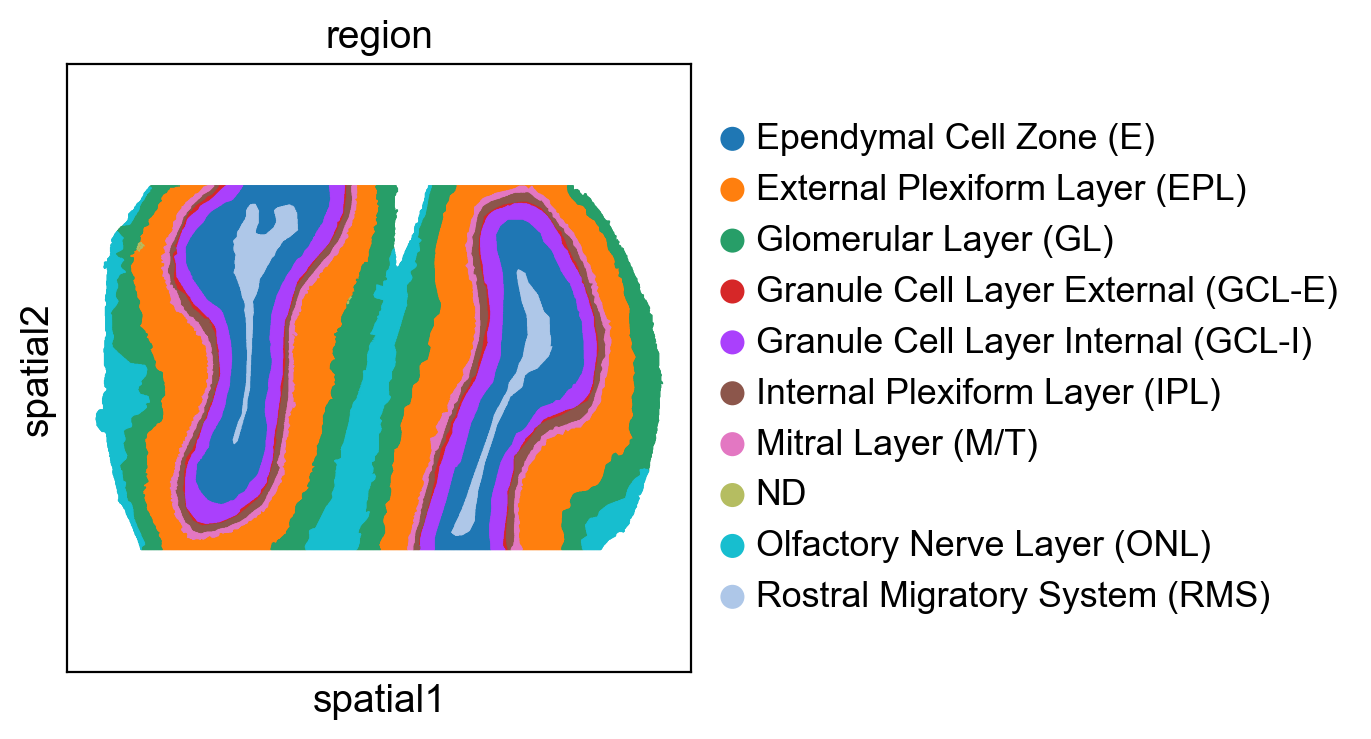

In [5]:
f, ax = plt.subplots()
sc.pl.scatter(adata, basis='spatial', color='region', size=1, ax=ax, show=False)
ax.axis('equal');

# Spatial binning

In [6]:
def matrix2long(x):
    nrow, ncol = x.shape
    xs = np.repeat(np.arange(1, nrow+1), ncol)
    ys = np.tile(np.arange(1, ncol+1), nrow)
    xflat = x.reshape(-1, 1).squeeze()
    
    return xs, ys, xflat

def spatial_bin(x, y, counts, bins, ranges=None, expand_binnumbers=False):
    binres = sp.stats.binned_statistic_2d(x, y, counts, bins=bins, statistic='sum', range=ranges, expand_binnumbers=expand_binnumbers)
    ret = matrix2long(binres.statistic)
        
    return ret, binres.binnumber if expand_binnumbers else None

def spatial_bin_adata(adata, cat_name, binno_colname, bins, ranges=None):
    adata_bin = sc.AnnData(np.zeros((np.prod(bins), adata.n_vars)))
    adata_bin.var_names = adata.var_names
    adata_bin.var = adata.var

    for i, g in enumerate(tqdm_notebook(adata.var_names)):
        (x, y, data), binno = spatial_bin(adata.obs.x, 
                                          adata.obs.y, 
                                          adata[:, g].X, 
                                          bins=bins, 
                                          ranges=ranges,
                                          expand_binnumbers=(i==(adata.n_vars-1)))

        adata_bin[:, g].X = data

    adata_bin.obs['x'] = x
    adata_bin.obs['y'] = y
    adata.obsm[binno_colname] = binno.T

    dfobs = bin_categorical(adata, cat_name, binno[0, :], binno[1, :])

    df = pd.merge(adata_bin.obs, dfobs, how='left', left_on=['x', 'y'], right_on=['bin_x', 'bin_y'], sort=False).reset_index(drop=True)
    df.index = df.index.astype(str)
    df = df.drop(['bin_x', 'bin_y'], axis=1)
    df.fillna(0, inplace=True)

    adata_bin.obs = df
    assert not adata_bin.obs.isnull().values.any()

    return adata_bin

def bin_categorical(adata, cat_name, bin_x, bin_y):
    # make a DF for the .obs
    dfobs = adata.obs.copy()
    dfobs['bin_x'] = bin_x
    dfobs['bin_y'] = bin_y
    
    # group observations based on bins, calculate category frequencies
    dfobs = pd.DataFrame(dfobs.groupby(['bin_x', 'bin_y'], sort=False)[cat_name].value_counts(normalize=True, sort=False)).rename(columns={cat_name: 'freq'})
    dfobs = dfobs.pivot_table(values='freq', columns=cat_name, index=['bin_x', 'bin_y'], fill_value=0)

    dfobs.reset_index(inplace=True)
    dfobs.index = dfobs.index.astype(str)
    dfobs.columns.name = None
    
    return dfobs

### Read bead coordinates

In [7]:
bead_coords = pd.read_csv('data/barcode_coordinates.txt', sep='\t').round()

### Lower resolution to make it roughly comparable to standard ST

In [8]:
def calc_bins_and_ranges(factor, bead_coords, factor_mult=0.):
    bins = np.ceil(np.ptp(bead_coords.V1)/factor).astype(int), np.ceil(np.ptp(bead_coords.V2)/factor).astype(int)
    ranges = (-factor*factor_mult, (bins[0]+factor_mult)*factor), (-factor*factor_mult, (bins[1]+factor_mult)*factor)
    return bins, ranges

In [9]:
factor = 5
bins, ranges = calc_bins_and_ranges(factor, bead_coords)
bins, ranges

/Users/geraslan/.anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


((384, 157), ((-0.0, 1920.0), (-0.0, 785.0)))

## Beads per bin (using all beads)

(-0.5, 383.5, 156.5, -0.5)

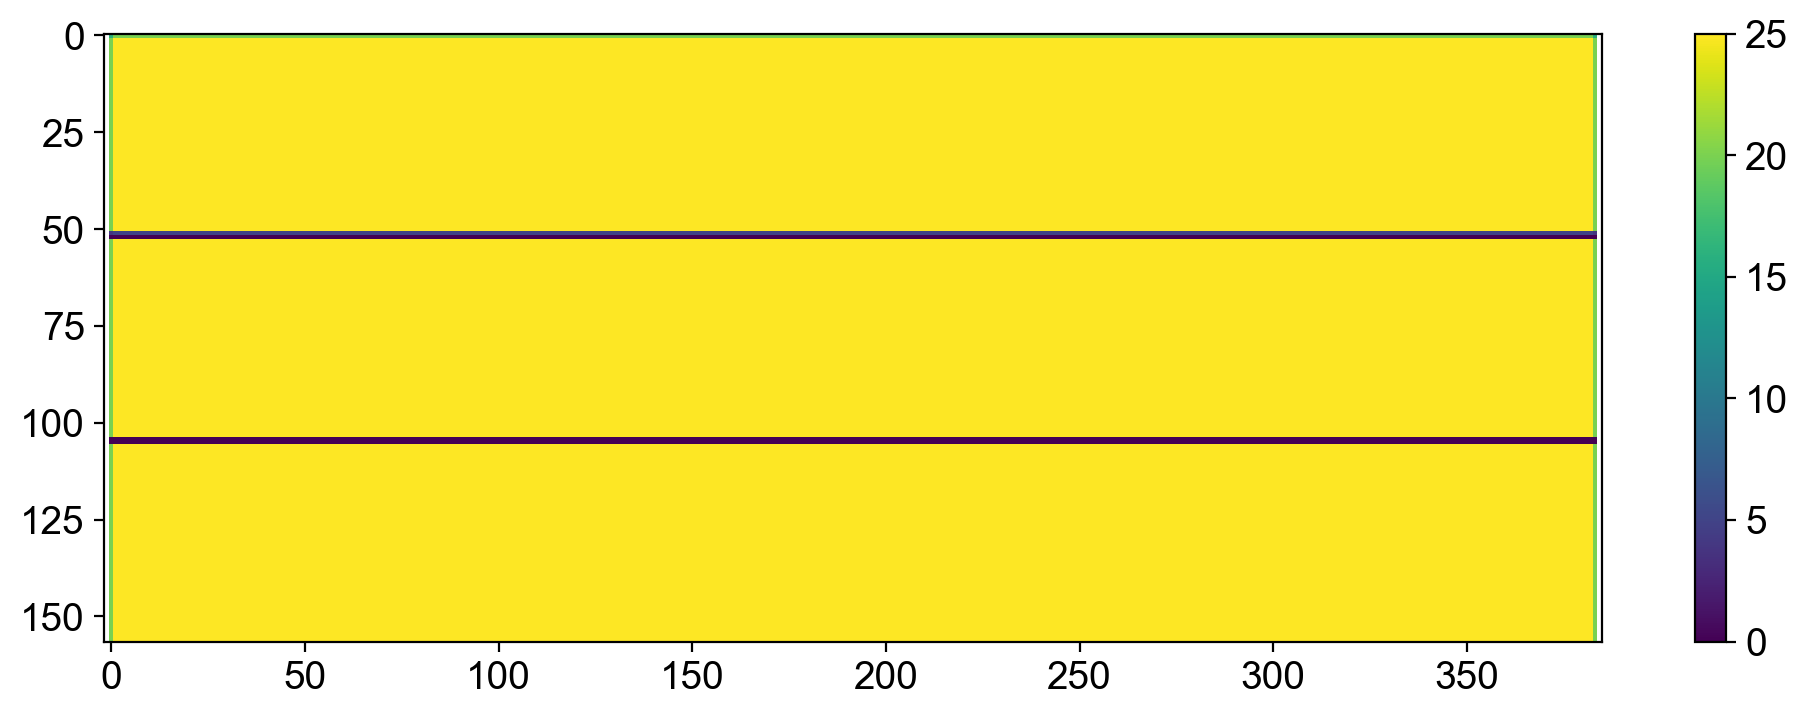

In [10]:
f, ax = plt.subplots(figsize=(12, 4))

beadres = sp.stats.binned_statistic_2d(bead_coords.V1, 
                                       bead_coords.V2, 
                                       np.ones((len(bead_coords))), 
                                       bins=bins, statistic='sum',
                                       range=ranges)

plt.imshow(beadres.statistic.T)
plt.colorbar();
ax.grid(False)
ax.axis('equal')

In [11]:
beadres.statistic.mean()

24.33767914012739

## Beads per bin (using only beads under tissue)

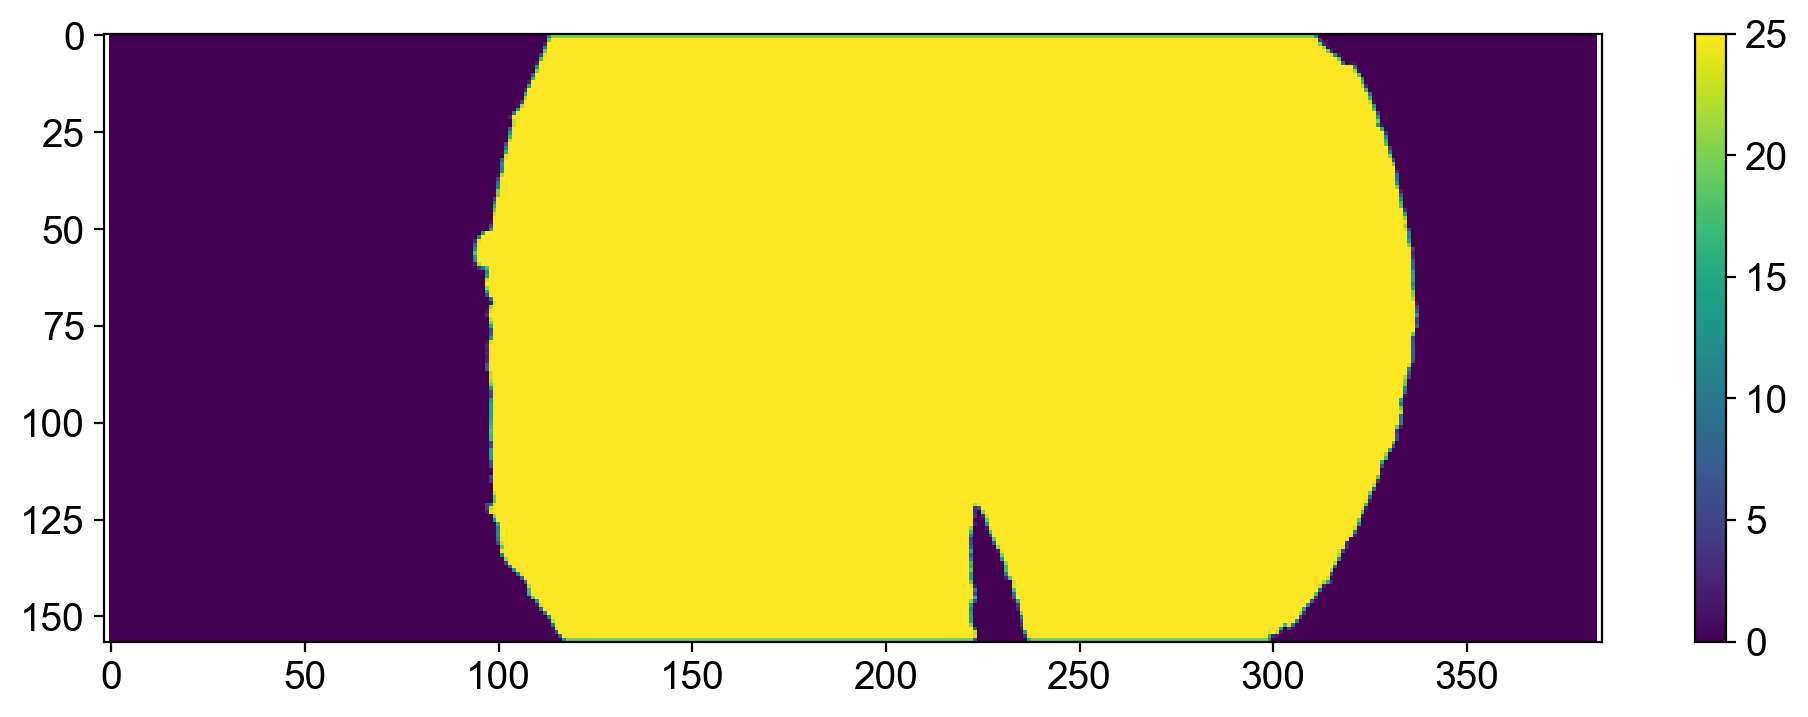

In [12]:
f, ax = plt.subplots(figsize=(12, 4))
beadres = sp.stats.binned_statistic_2d(adata.obs.x, 
                                       adata.obs.y, 
                                       np.ones((len(adata))), 
                                       bins=bins, statistic='sum',
                                       range=ranges,
                                       expand_binnumbers=True)
 
plt.imshow(beadres.statistic.T)
plt.colorbar();
ax.grid(False)
ax.axis('equal');

## Beads per bin (using only beads with expression)

In [13]:
adata

AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial'

In [14]:
adata.obs.region.value_counts()

External Plexiform Layer (EPL)         252949
Ependymal Cell Zone (E)                162703
Glomerular Layer (GL)                  158629
Granule Cell Layer Internal (GCL-I)     89456
Olfactory Nerve Layer (ONL)             78074
Internal Plexiform Layer (IPL)          44757
Mitral Layer (M/T)                      35198
Rostral Migratory System (RMS)          32264
Granule Cell Layer External (GCL-E)     20743
ND                                         91
Name: region, dtype: int64

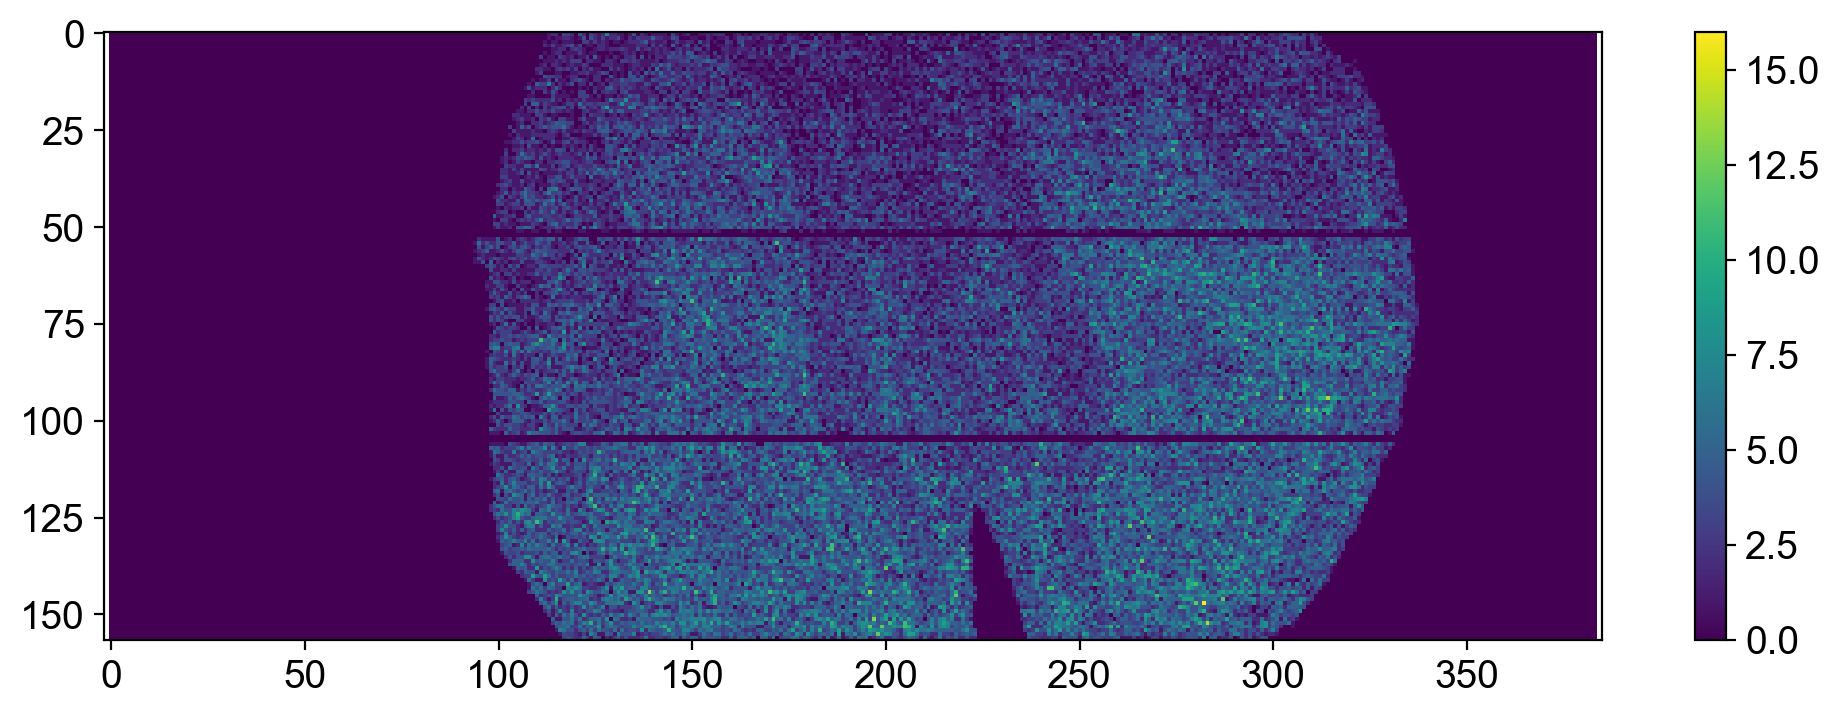

In [15]:
f, ax = plt.subplots(figsize=(12, 4))
ad = sc.pp.filter_cells(adata, min_counts=1, copy=True)
beadres = sp.stats.binned_statistic_2d(ad.obs.x, 
                                       ad.obs.y, 
                                       np.ones((len(ad))), 
                                       bins=bins, statistic='sum',
                                       range=ranges,
                                       expand_binnumbers=True)
 
plt.imshow(beadres.statistic.T)
plt.colorbar();
ax.grid(False)
ax.axis('equal');

## Perform binning

In [17]:
adata_lowres = spatial_bin_adata(adata, 'region', '%sx' % factor, bins, ranges)

In [18]:
adata_lowres

AnnData object with n_obs × n_vars = 60288 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)'
    var: 'gene_symbols', 'gene_ids'

In [19]:
adata

AnnData object with n_obs × n_vars = 874864 × 16208 
    obs: 'region', 'segment', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial', '5x'

In [20]:
# save files as CSV
pd.DataFrame(adata_lowres.X, columns=adata_lowres.var_names).to_csv('results/hdst-lowres-%dx.csv.gz' % factor, index=False, compression='gzip')
pd.DataFrame(adata_lowres.obs, index=None).to_csv('results/hdst-lowres-%dx-bins.csv.gz' % factor, index=False, compression='gzip')

In [20]:
adata_lowres.write(f'results/hdst-lowres-{factor}x.h5ad')
adata.write('results/hdst.h5ad')

... storing 'region' as categorical
... storing 'segment' as categorical


In [9]:
adata_lowres

AnnData object with n_obs × n_vars = 60288 × 14219 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)'
    var: 'gene_symbols', 'gene_ids'

### Mean bead per bin

In [21]:
m = beadres.statistic.T
m[m>0].mean()

175.31530139103555

## QC

In [24]:
qc = sc.pp.calculate_qc_metrics(sc.pp.filter_cells(adata_lowres, min_counts=1, copy=True))

Text(0, 0.5, 'Number of expressed genes')

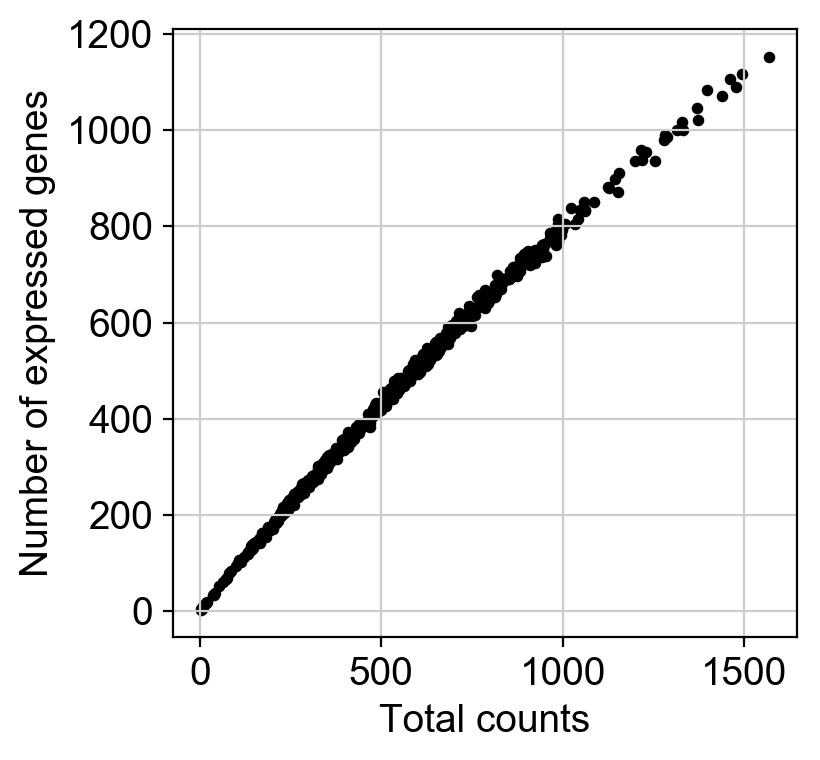

In [25]:
plt.scatter(qc[0].total_counts, qc[0].n_genes_by_counts, c='k', s=10)
plt.xlabel('Total counts')
plt.ylabel('Number of expressed genes')

Text(0.5, 1.0, 'Total counts per gene')

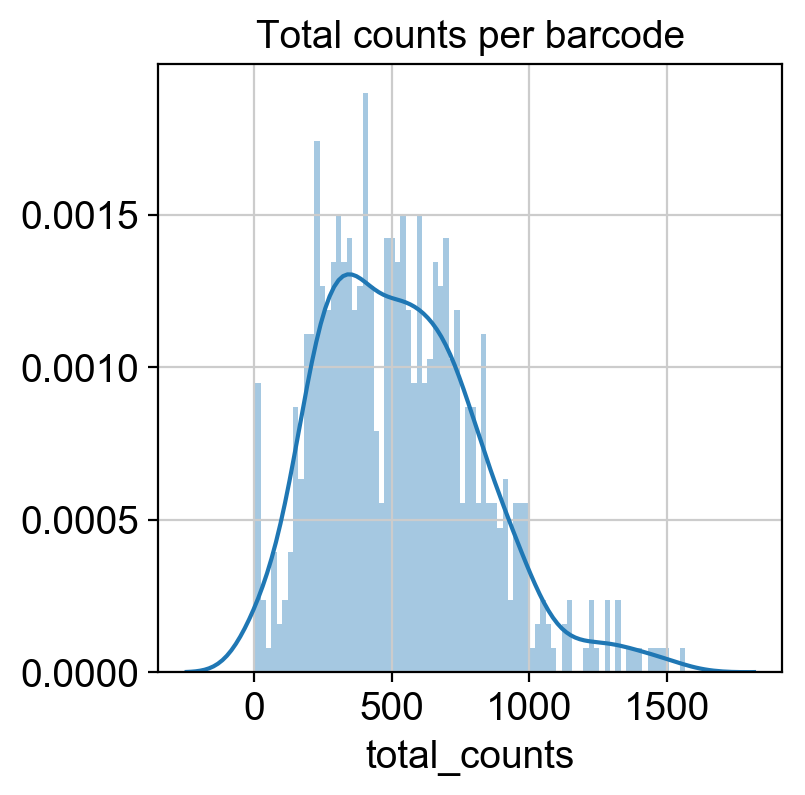

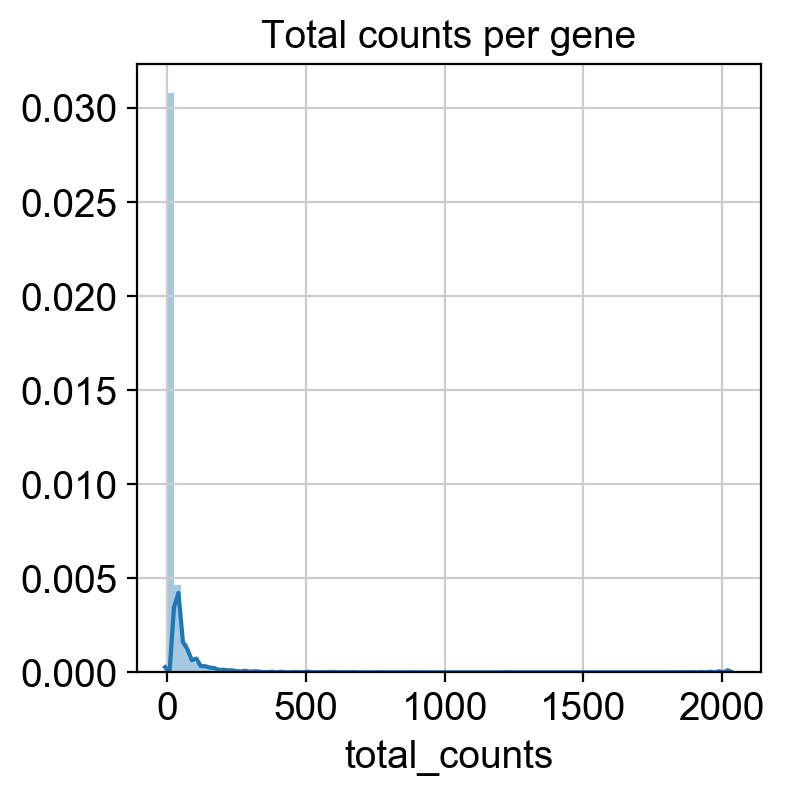

In [26]:
sns.distplot(qc[0].total_counts, bins=80)
plt.title('Total counts per barcode')
plt.figure()
sns.distplot(qc[1].total_counts, bins=80)
plt.title('Total counts per gene')

### Visualize binning

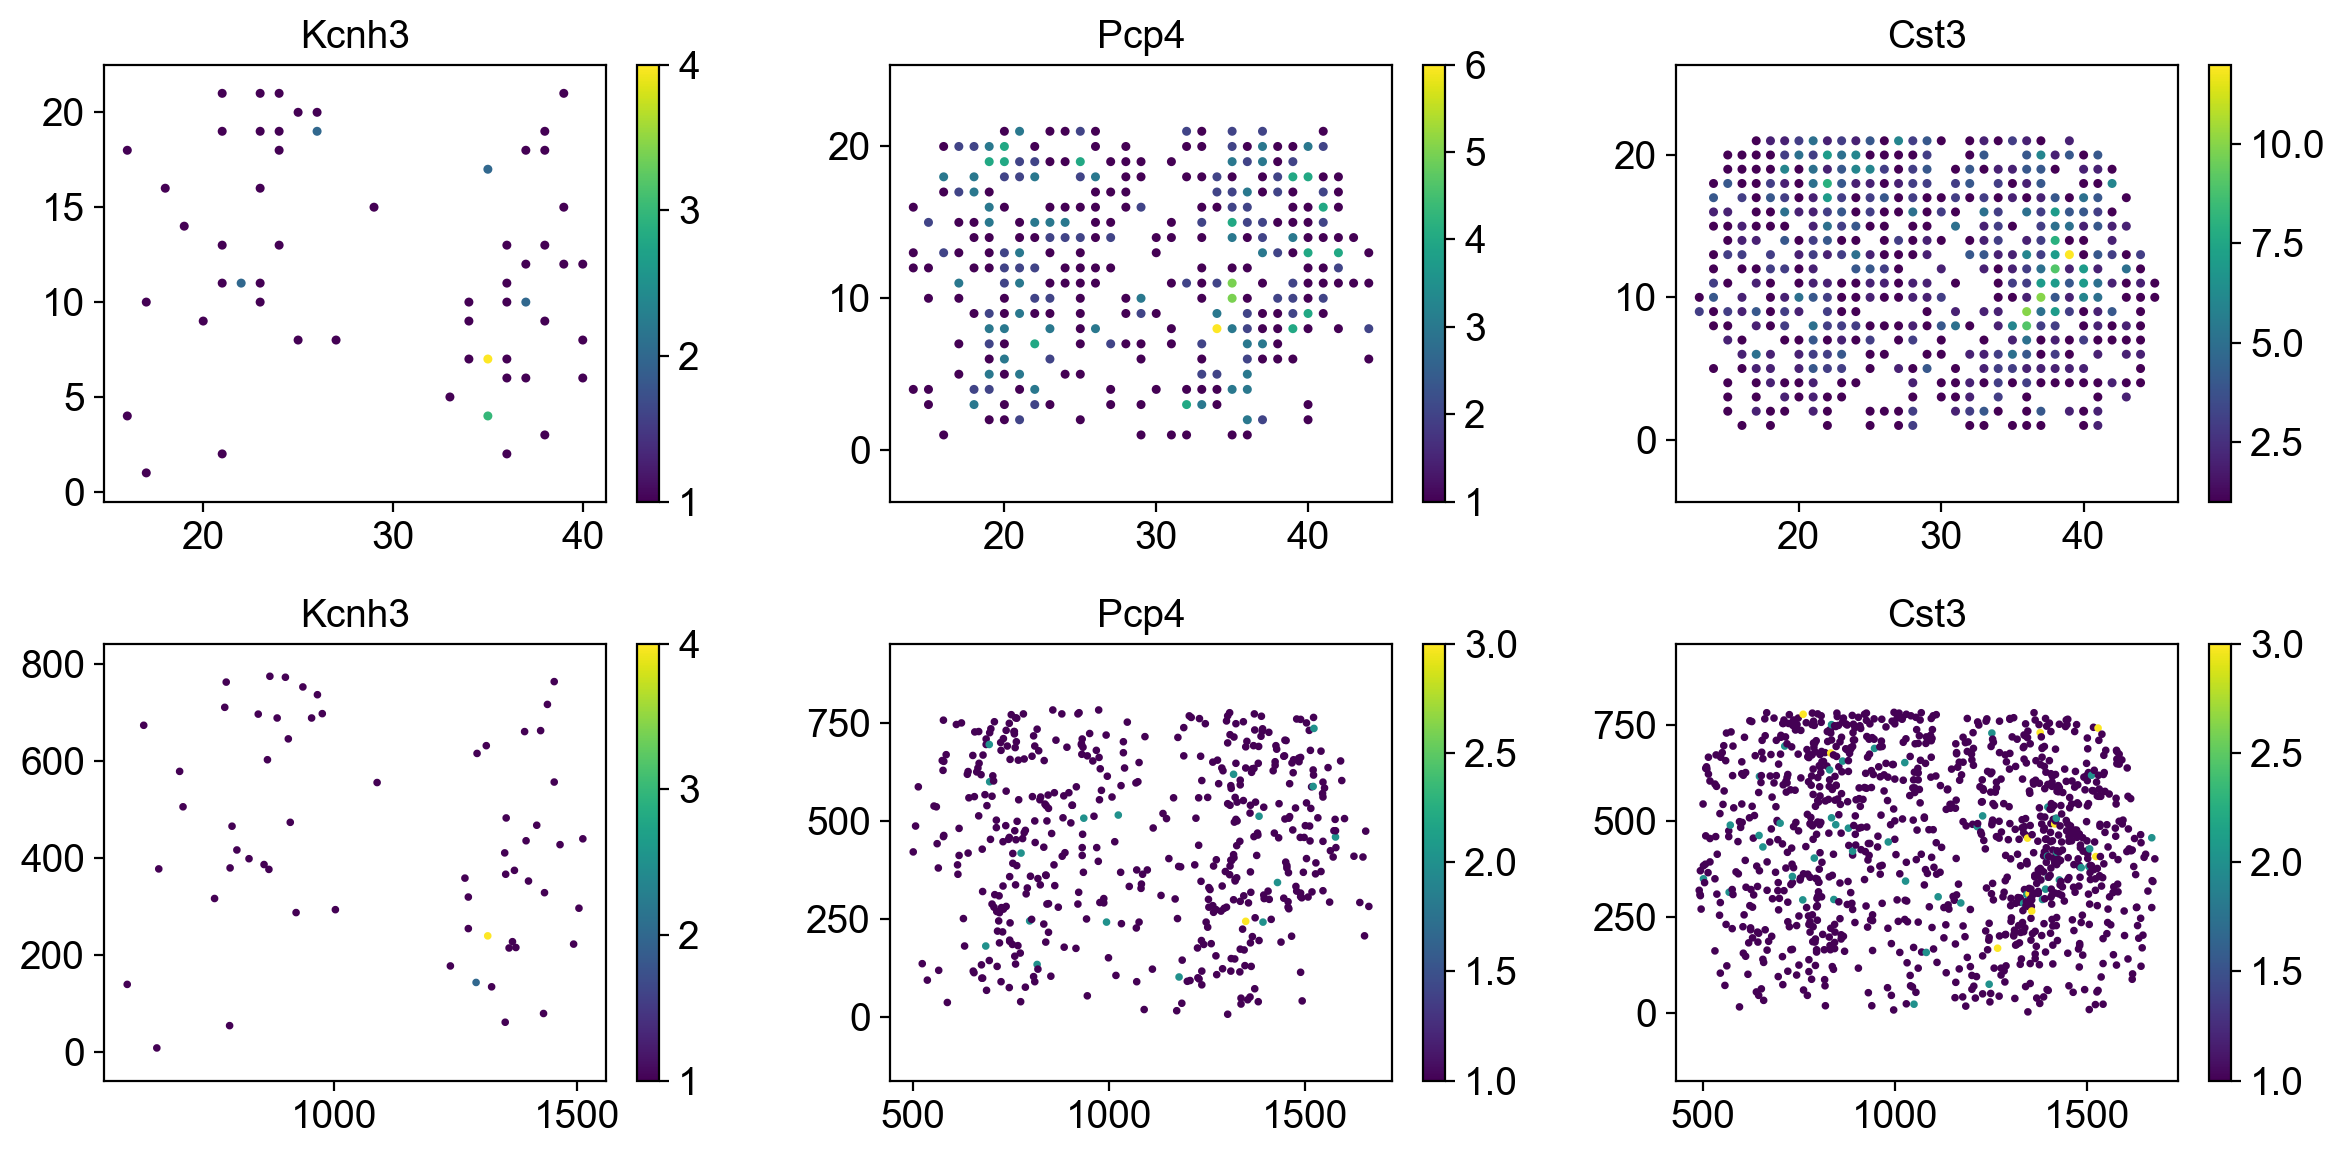

In [27]:
f = plt.figure(figsize=(12, 6))

for i, g in enumerate(['Kcnh3', 'Pcp4', 'Cst3']):
    ax = plt.subplot(2, 3, i + 1)
    ax.grid(False)

    ad = adata_lowres[:, g]
    ad = ad[ad.X>0]    
    plt.scatter(ad.obs.x, ad.obs.y, c=ad.X, s=5);
    plt.title(g)
    plt.axis('equal')
    plt.colorbar();

for i, g in enumerate(['Kcnh3', 'Pcp4', 'Cst3']):
    ax = plt.subplot(2, 3, i + 1 + 3)
    ax.grid(False)
    
    ad = adata[:, g]
    ad = ad[ad.X>0]
    plt.scatter(ad.obs.x.values, ad.obs.y.values, c=ad.X, s=3);
    plt.title(g)
    plt.axis('equal')
    plt.colorbar();
    
plt.tight_layout()

## Save as csv

In [28]:
pd.DataFrame(sc.pp.filter_cells(adata_lowres, 
                                min_counts=1, 
                                copy=True).X, 
             columns=adata.var_names).to_csv('results/hdst-lowres-%sx.csv.gz' % factor, index=False, compression='gzip')

pd.DataFrame(sc.pp.filter_cells(adata_lowres, 
                                min_counts=1, 
                                copy=True).obs).to_csv('results/hdst-lowres-%sx-bins.csv.gz' % factor, index=False, compression='gzip')

## Generate another resolution level

5 (384, 157)


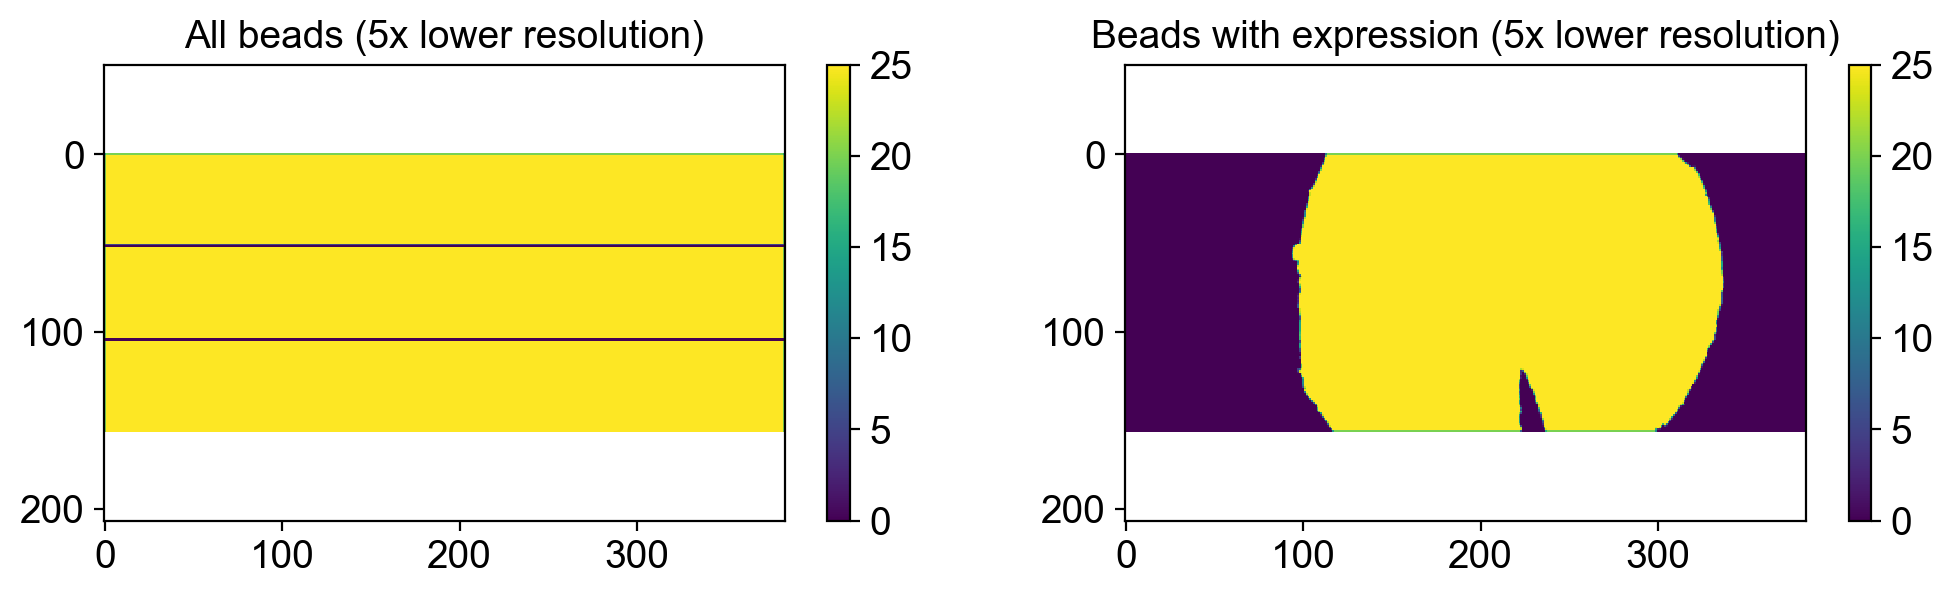

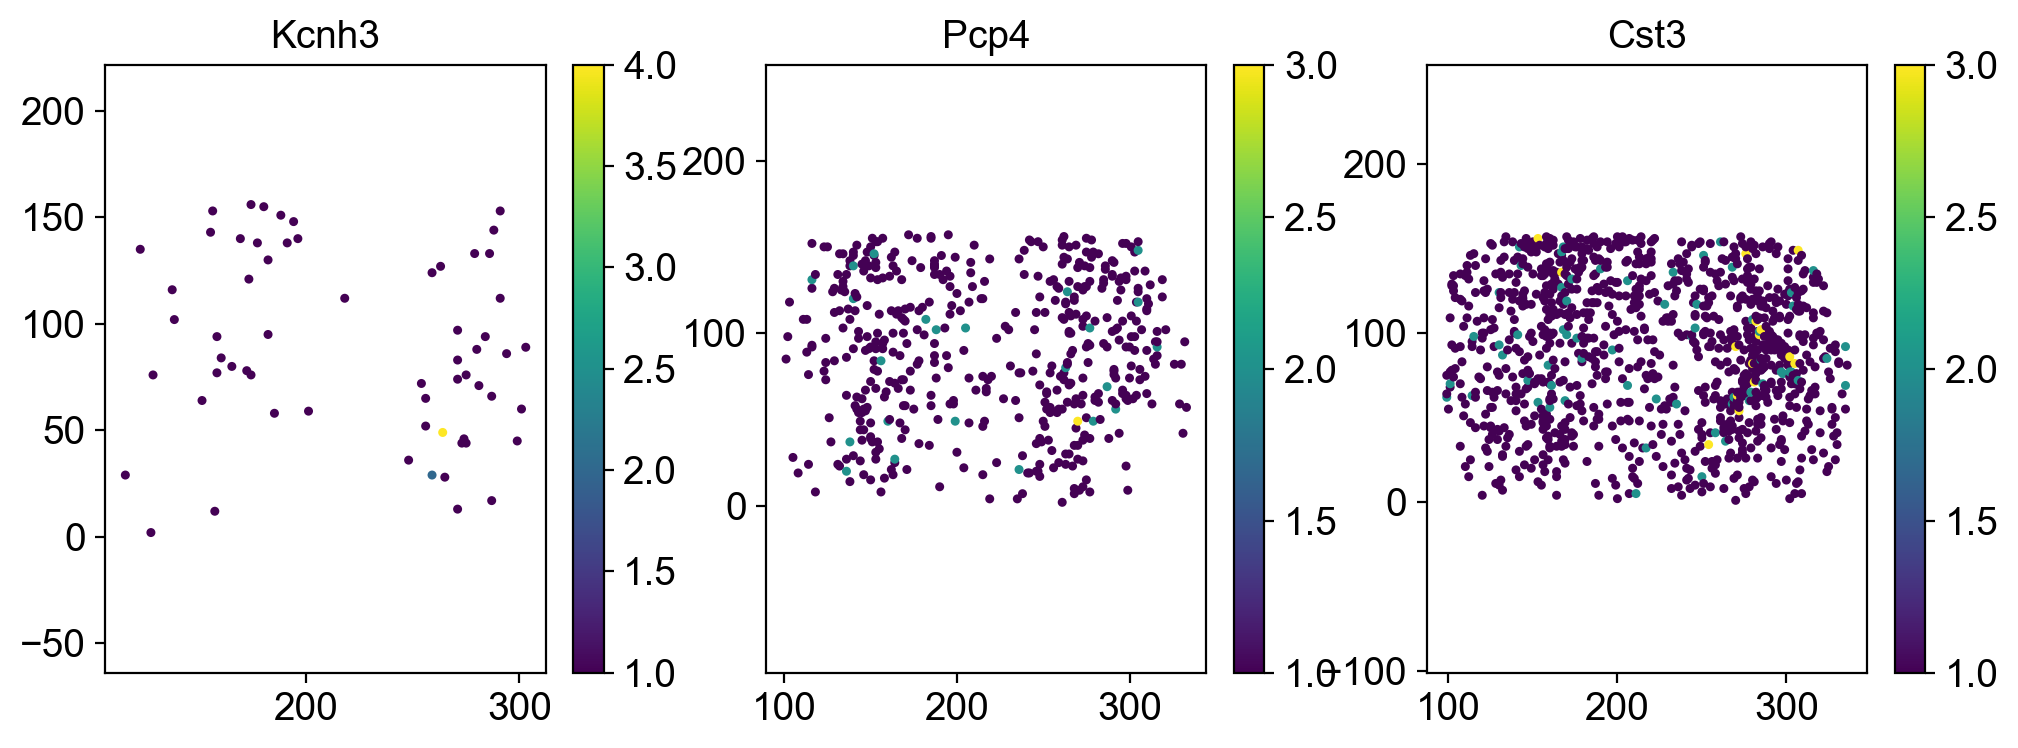

In [29]:
factor_mult = 0.

for factor in (5,):

    bins, ranges = calc_bins_and_ranges(factor, bead_coords)
    print(factor, bins)

    f, axs = plt.subplots(1, 2, figsize=(12, 3))

    beadres = sp.stats.binned_statistic_2d(bead_coords.V1, 
                                           bead_coords.V2, 
                                           np.ones((len(bead_coords))), 
                                           bins=bins, statistic='sum',
                                           range=ranges)

    cl = axs[0].imshow(beadres.statistic.T)
    axs[0].grid(False)
    axs[0].axis('equal')
    axs[0].set_title('All beads (%dx lower resolution)' % factor)
    plt.colorbar(cl, ax=axs[0])
    
    beadres = sp.stats.binned_statistic_2d(adata.obs.x, 
                                           adata.obs.y, 
                                           np.ones((len(adata))), 
                                           bins=bins, statistic='sum',
                                           range=ranges,
                                           expand_binnumbers=True)
    cl = axs[1].imshow(beadres.statistic.T)
    axs[1].grid(False)
    axs[1].axis('equal')
    axs[1].set_title('Beads with expression (%dx lower resolution)' % factor)
    plt.colorbar(cl, ax=axs[1])

    adata_low = spatial_bin_adata(adata, 'region', '%sx' % factor, bins, ranges)
    
    f = plt.figure(figsize=(12, 4))
    
    # Plot some genes
    for i, g in enumerate(['Kcnh3', 'Pcp4', 'Cst3']):
        ax = plt.subplot(1, 3, i + 1)
        ax.grid(False)

        ad = adata_low[:, g]
        ad = ad[ad.X>0]    
        plt.scatter(ad.obs.x, ad.obs.y, c=ad.X, s=5);
        plt.title(g)
        plt.axis('equal')
        plt.colorbar();

    # save the file as h5ad
    sc.write('results/hdst-lowres-%dx.h5ad' % factor, adata_low)
    sc.pp.filter_cells(adata_low, min_counts=1)
    
    # save files as CSV
    pd.DataFrame(adata_low.X, columns=adata_low.var_names).to_csv('results/hdst-lowres-%dx.csv.gz' % factor, index=False, compression='gzip')
    pd.DataFrame(adata_low.obs, index=None).to_csv('results/hdst-lowres-%dx-bins.csv.gz' % factor, index=False, compression='gzip')

In [30]:
adata

AnnData object with n_obs × n_vars = 874864 × 14219 
    obs: 'region', 'x', 'y'
    var: 'gene_symbols', 'gene_ids'
    uns: 'region_colors'
    obsm: 'X_spatial', '38x', '5x'

In [31]:
adata.write('results/hdst.h5ad')

## Save coordinate mappings

In [32]:
dfs = []
for factor in (5, 38):
    dfs.append(pd.DataFrame(adata.obsm['%sx' % factor], columns=['%sx_x' % factor, '%sx_y' % factor]))
    
coord_df = pd.concat(dfs, axis=1)
coord_df.head()

,5x_x,5x_y,38x_x,38x_y
0,201,1,27,1
1,201,3,27,1
2,201,21,27,3
3,201,21,27,3
4,201,21,27,3


In [33]:
coord_df = pd.concat([adata.obs.reset_index(drop=True), coord_df], axis=1)
coord_df.rename(columns={'x': 'orig_x', 'y': 'orig_y'}, inplace=True)
#coord_df.drop('n_counts', axis=1, inplace=True)
coord_df.head()

,region,orig_x,orig_y,5x_x,5x_y,38x_x,38x_y
0,Olfactory Nerve Layer (ONL),1000,1,201,1,27,1
1,Olfactory Nerve Layer (ONL),1000,10,201,3,27,1
2,Olfactory Nerve Layer (ONL),1000,100,201,21,27,3
3,Olfactory Nerve Layer (ONL),1000,101,201,21,27,3
4,Olfactory Nerve Layer (ONL),1000,102,201,21,27,3


In [34]:
coord_df.to_csv('results/hdst-lowres-coordinates.csv', index=False)